### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).
Data description

1.city: city this user signed up in

2.phone: primary device for this user

3.signup_date: date of account registration; in the form ‘YYYYMMDD’

4.last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

5.avg_dist: the average distance in miles per trip taken in the first 30 days after signup

6.avg_rating_by_driver: the rider’s average rating over all of their trips

7.avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

8.surge_pct: the percent of trips taken with surge multiplier > 1

9.avg_surge: The average surge multiplier over all of this user’s trips

10.trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

11.ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

11.weekday_pct: the percent of the user’s trips occurring during a weekday

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
pd.read_json('ultimate_data_challenge.json').to_csv('UDC.csv',index=0)

In [3]:
df=pd.read_csv('UDC.csv',parse_dates=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [5]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [6]:
df['signup_date']=pd.to_datetime(df['signup_date'])
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])

In [7]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [16]:
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(),inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(),inplace=True)


In [22]:
df['phone'].fillna(df['phone'].mode()[0],inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

####  Descriptive Statistics and EDA(Exploratory Data Anaylsis) 

In [ ]:
# For Numerical Columns

In [24]:
# Descriptive Statistics For Numerical Columns
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [ ]:
#For Categorical Columns City,Phone and ultimate_black_user

city
King's Landing    10130
Astapor           16534
Winterfell        23336
Name: phone, dtype: int64
phone
Android    15022
iPhone     34978
Name: city, dtype: int64
ultimate_black_user
True     18854
False    31146
Name: phone, dtype: int64


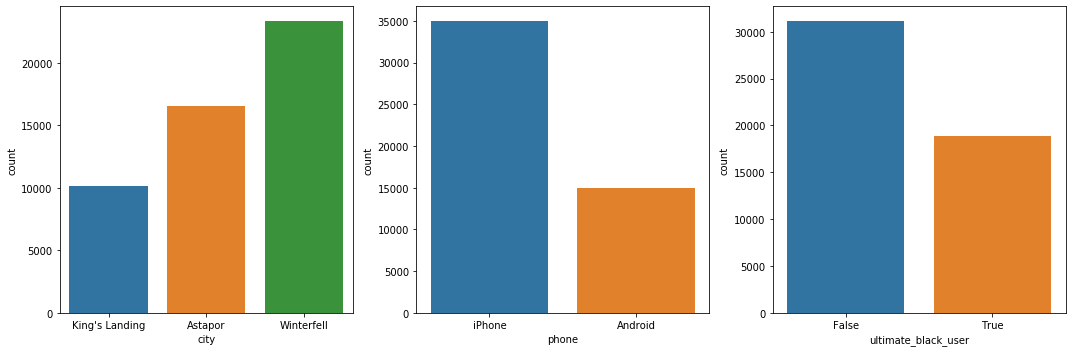

In [58]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.countplot('city',data=df)
print(df.groupby('city').count()['phone'].sort_values())
plt.subplot(1,3,2)
sns.countplot('phone',data=df)
print(df.groupby('phone').count()['city'].sort_values())
plt.subplot(1,3,3)
sns.countplot('ultimate_black_user',data=df)
print(df.groupby('ultimate_black_user').count()['phone'].sort_values())
plt.tight_layout()
plt.show()

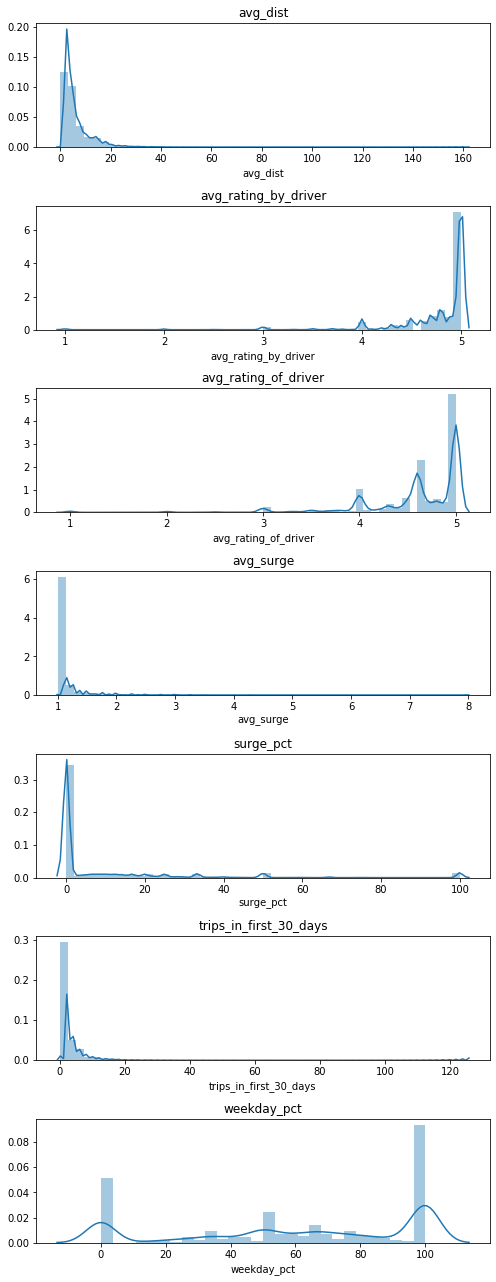

In [72]:
#For Numerical Columns
# Show distributions of numerical features


num_col = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                      'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']
plt.figure(figsize=(7,20))
i=1
for n in num_col:
    plt.subplot(8,1,i)
    i+=1
    sns.distplot(df[n])
    plt.title(n)
    
plt.tight_layout()
plt.show()

##### 1.Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

##### Assumptions.
*1.We need to find the Percentage of users who were active in the last 30 days when the data was recorded.
*2.It is not given when the data was recorded, So will use the last date/latest trip date as the observation date.



In [83]:
obs_date=df['last_trip_date'].max()
print('Observation_Date:',obs_date)

Day_Threshold=obs_date-pd.Timedelta('30 days')
print('Day_Threshold:',Day_Threshold)

Observation_Date: 2014-07-01 00:00:00
Day_Threshold: 2014-06-01 00:00:00


In [91]:
Fraction_Users_retained=len(df[(df['last_trip_date']>Day_Threshold)])*100/len(df)

print('Fraction_Users_retained %',Fraction_Users_retained)

Fraction_Users_retained % 36.62


#### 36.62% of users were as checked on the Observed date 01-07-2014


#### 2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [116]:
df['rider_ret'] = (df['last_trip_date'] > Day_Threshold)



In [105]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,rider_ret
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [117]:
# Drop datetime features
del df['signup_date']
del df['last_trip_date']

In [119]:
# Creating dummy variables for categorical features
ndf = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [120]:
ndf.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,rider_ret,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,True,1,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,False,0,0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,False,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,True,1,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,False,0,1,0,0


In [121]:
X = ndf.drop('rider_ret', axis=1)
y = ndf['rider_ret']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37500, 11)
(12500, 11)
(37500,)
(12500,)


#####  Applying Machine Learning 

In [123]:
clf = RandomForestClassifier()
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.76546667 0.768      0.76133333 0.77386667 0.76373333]
Average 5-Fold CV Score: 0.7664799999999999


#### So, using Random Forest Claasifier with default parameters, we can get a model with 76.64% accuracy.

In [126]:
# Create the hyperparameter grid
n_options = [10,20,50,100]
feature_options = [5, 8, 10, 'auto', None]
param_grid = {'n_estimators': n_options, 'max_features': feature_options}


In [127]:
# Instantiate the GridSearchCV object
clf_cv = GridSearchCV(clf, param_grid, cv=5)
# build model    
clf_cv.fit(X_train, y_train)
# predict using model
y_predict = clf_cv.predict(X_test)

In [129]:
 #Print the optimal parameters and best score
print("Tuned Parameter: {}".format(clf_cv.best_params_))
print("Tuned Score: {}".format(clf_cv.best_score_))

# evaluate model prediction performance 
print ('Test set performance:')
print ('Accuracy: ', accuracy_score(y_test,y_predict))
print (classification_report(y_test, y_predict))

Tuned Parameter: {'max_features': 8, 'n_estimators': 100}
Tuned Score: 0.7682666666666667
Test set performance:
Accuracy:  0.75896
              precision    recall  f1-score   support

       False       0.80      0.82      0.81      7924
        True       0.68      0.65      0.66      4576

    accuracy                           0.76     12500
   macro avg       0.74      0.74      0.74     12500
weighted avg       0.76      0.76      0.76     12500



##### Final Model

In [130]:
rfc = RandomForestClassifier(n_estimators=100, max_features=8)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [132]:
# Generate classification report
print(classification_report(y_test, y_pred))
print('Test set accuracy: {:.2f}%'.format(accuracy_score(y_test, y_pred)*100))

              precision    recall  f1-score   support

       False       0.81      0.82      0.81      7924
        True       0.68      0.66      0.67      4576

    accuracy                           0.76     12500
   macro avg       0.74      0.74      0.74     12500
weighted avg       0.76      0.76      0.76     12500

Test set accuracy: 76.26%


In [133]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=range(0,2), columns=range(0,2))

,0,1
0,6535,1389
1,1578,2998


Text(0.5, 1.0, 'ROC Curve')

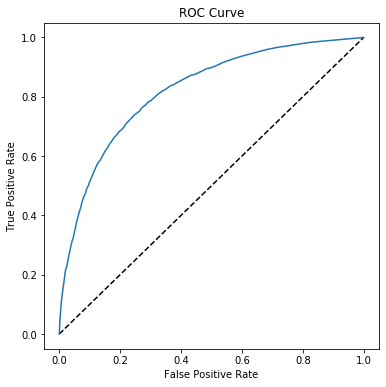

In [134]:
# Compute predicted probabilities
y_pred_prob = rfc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [135]:
# Compute and print AUC score
print("AUC: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.8205


#### Final Scores of the Model  after HyperParameter tuning and AUC are below:
    Accuracy:76.26%
    AUC: 0.8205

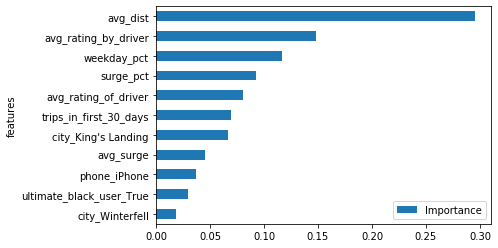

In [161]:
Key_features = pd.DataFrame(list(zip(X.columns, rfc.feature_importances_)), columns = ['features', 'Importance'])
Key_features.set_index('features',inplace=True)
Key_features.sort_values(by='Importance').plot(kind='barh')

#### 3.Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

1.Since average distance one of the Most Important feature, The riders needs to be encouraged to take longer trips by giving discount coupons for every new user for the first 30 days.

2.Improve Avg_rating by Driver By giving good service to get higher ratings

3.Increase the no of trips took on weekdays